In [11]:
import mdtraj as md
import mdfeature.features as features
import numpy as np

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
font = {'family' : 'sans-serif',
        'size'   : 14.0}
mpl.rc('font', **font) 
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] =  16
mpl.rcParams['font.size'] =  15
mpl.rcParams['figure.autolayout'] =  True
mpl.rcParams['figure.figsize'] =  7.2,4.45
mpl.rcParams['axes.titlesize'] =  16
mpl.rcParams['axes.labelsize'] =  17
mpl.rcParams['lines.linewidth'] =  2
mpl.rcParams['lines.markersize'] =  6
mpl.rcParams['legend.fontsize'] =  13

Load topology and trajectory

In [19]:
temperature = 300
beta = 1.0/(temperature*0.0083144621)

pdb_name = "alanine.pdb"
mdinit = md.load_pdb(pdb_name)
topology = md.load(pdb_name).topology
table, bonds = topology.to_dataframe()
traj_std_tmp = md.load_dcd('test_traj.dcd', mdinit.topology)
skip_first = 1000
traj_orig = traj_std_tmp[skip_first:]
print(traj_orig)
traj_orig = traj_orig.superpose(traj_orig[0])

<mdtraj.Trajectory with 9001 frames, 22 atoms, 3 residues, without unitcells>


Compute phi trajectory

In [14]:
#dihedral coordinates of analine dipeptide 
phi = [4, 6, 8 ,14] 
psi = [6, 8, 14, 16]
phi_name = features.get_name_torsion(phi, pdb_file=pdb_name, table=table)
psi_name = features.get_name_torsion(psi, pdb_file=pdb_name, table=table)
phi_torsion = features.compute_torsion_mdraj(traj_orig, phi)
psi_torsion = features.compute_torsion_mdraj(traj_orig, psi)

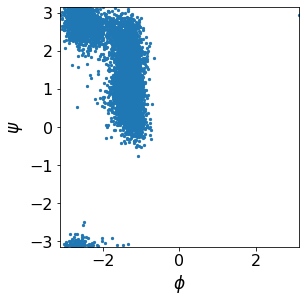

In [34]:
plt.scatter(phi_torsion, psi_torsion, s=5)
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\psi$')
plt.gca().set_aspect('equal')
plt.show()

Compute 2D free energy

In [16]:
from mdfeature.ConvergenceAnalyser import free_energy_estimate_2D

In [26]:
free_energy, xedges, yedges = free_energy_estimate_2D(np.array([phi_torsion, psi_torsion]).T, beta, bins=100)

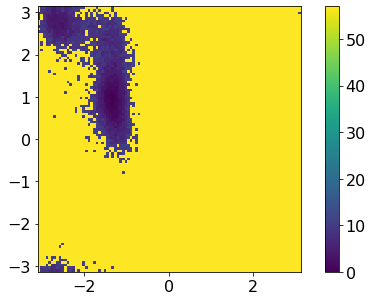

In [35]:
fig, ax = plt.subplots()
im = ax.pcolormesh(xedges, yedges, free_energy.T)
plt.colorbar(im)
plt.gca().set_aspect('equal')
plt.show()